In [3]:
# ===========================================
# 📦 INSTALL DEPENDENCIES
# ===========================================
!pip install yfinance scikit-learn pandas numpy matplotlib joblib --quiet

In [5]:
# ===========================================
# 📥 1. DATA COLLECTION (REAL NSE STOCKS)
# ===========================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from datetime import timedelta

# 10 major Indian NSE companies
tickers = [
    "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "ICICIBANK.NS",
    "SBIN.NS", "BHARTIARTL.NS", "KOTAKBANK.NS", "LT.NS", "ITC.NS"
]

print("📥 Downloading daily data (2010–2025) for 10 Indian companies...")
data = yf.download(tickers, start="2010-01-01", end="2025-01-01", group_by='ticker', progress=False)

frames = []
for t in tickers:
    df_t = data[t].reset_index()
    df_t["Ticker"] = t.replace(".NS", "")
    frames.append(df_t)

df = pd.concat(frames)
df = df.rename(columns=str.capitalize)
df = df[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']]
df = df.dropna().reset_index(drop=True)

# ✅ Save raw data
save_path = "indian_stocks.csv"
df.to_csv(save_path, index=False)
print(f"✅ Data collected for {df['Ticker'].nunique()} companies with {len(df):,} rows.")
print(f"💾 Saved to: {save_path}")

📥 Downloading daily data (2010–2025) for 10 Indian companies...


/tmp/ipython-input-2098289642.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2010-01-01", end="2025-01-01", group_by='ticker', progress=False)


✅ Data collected for 10 companies with 37,000 rows.
💾 Saved to: indian_stocks.csv


In [6]:
# ===========================================
# 🧹 2. DATA CLEANING
# ===========================================
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)
df = df.dropna()

In [8]:
# ===========================================
# ⚙️ 3. FEATURE ENGINEERING
# ===========================================
def create_features(df):
    df_fe = df.copy()
    df_fe["Close_lag_1"] = df_fe.groupby("Ticker")["Close"].shift(1)
    df_fe["Close_lag_2"] = df_fe.groupby("Ticker")["Close"].shift(2)
    df_fe["Close_lag_3"] = df_fe.groupby("Ticker")["Close"].shift(3)

    df_fe["Close_roll_mean_3"] = df_fe.groupby("Ticker")["Close"].transform(lambda x: x.rolling(3).mean())
    df_fe["Close_roll_mean_5"] = df_fe.groupby("Ticker")["Close"].transform(lambda x: x.rolling(5).mean())
    df_fe["Close_roll_mean_10"] = df_fe.groupby("Ticker")["Close"].transform(lambda x: x.rolling(10).mean())

    feat_cols = ['Close_lag_1', 'Close_lag_2', 'Close_lag_3',
                 'Close_roll_mean_3', 'Close_roll_mean_5', 'Close_roll_mean_10']

    # ✅ use transform instead of apply (preserves index)
    df_fe[feat_cols] = df_fe.groupby("Ticker")[feat_cols].transform(lambda g: g.bfill().ffill())

    df_fe = df_fe.dropna().reset_index(drop=True)
    return df_fe


df = create_features(df)
print("✅ Feature engineering complete.")

✅ Feature engineering complete.


In [9]:
# ===========================================
# 🔢 4. PREPROCESSING
# ===========================================
le = LabelEncoder()
df["Ticker_enc"] = le.fit_transform(df["Ticker"])

FEATURES = ['Ticker_enc', 'Open', 'High', 'Low', 'Volume',
            'Close_lag_1', 'Close_lag_2', 'Close_lag_3',
            'Close_roll_mean_3', 'Close_roll_mean_5', 'Close_roll_mean_10']
TARGET = 'Close'

train_list, test_list = [], []
for t in df["Ticker"].unique():
    df_t = df[df["Ticker"] == t]
    cutoff = int(len(df_t) * 0.8)
    train_list.append(df_t.iloc[:cutoff])
    test_list.append(df_t.iloc[cutoff:])

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test, y_test = test_df[FEATURES], test_df[TARGET]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Preprocessing complete.")

✅ Preprocessing complete.


In [16]:
# ===========================================
# 🤖 5. MODEL TRAINING
# ===========================================
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=12,

)
model.fit(X_train_scaled, y_train)
print("✅ Model training complete.")

✅ Model training complete.



📊 Model Evaluation:
MAE : 21.59
RMSE: 87.98
R²  : 0.9916


/tmp/ipython-input-3894533144.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


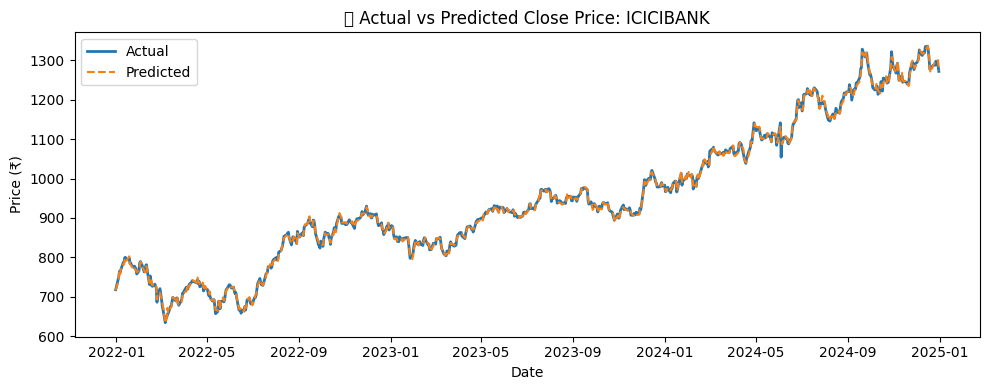

/tmp/ipython-input-3894533144.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


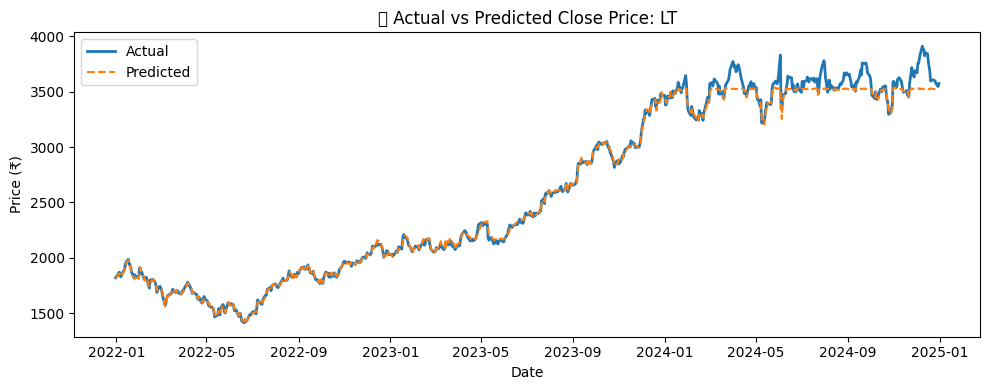

/tmp/ipython-input-3894533144.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


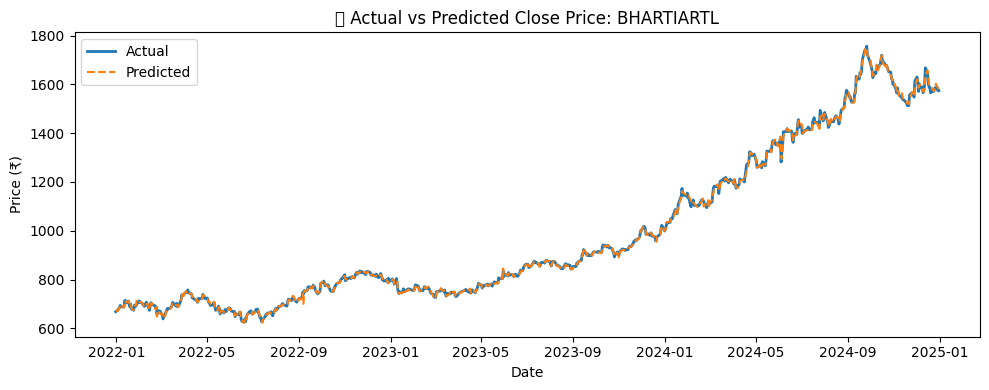


Top 10 Most Important Features:
High                  0.655682
Low                   0.320981
Close_roll_mean_3     0.011427
Close_roll_mean_5     0.004521
Close_lag_1           0.003279
Close_roll_mean_10    0.001772
Open                  0.001397
Close_lag_3           0.000477
Close_lag_2           0.000457
Volume                0.000007
dtype: float64


In [17]:
# ===========================================
# 🧪 6. MODEL TESTING & EVALUATION
# ===========================================
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
except TypeError:
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")

# Visual check for few tickers
unique_tickers = test_df["Ticker"].drop_duplicates().tolist()
n_samples = min(3, len(unique_tickers))
sample_tickers = np.random.choice(unique_tickers, size=n_samples, replace=False).tolist()

for t in sample_tickers:
    sel = test_df[test_df["Ticker"] == t]
    plt.figure(figsize=(10, 4))
    plt.plot(sel["Date"], sel["Close"], label="Actual", linewidth=2)
    plt.plot(sel["Date"], model.predict(scaler.transform(sel[FEATURES])), label="Predicted", linestyle="--")
    plt.title(f"📈 Actual vs Predicted Close Price: {t}")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Feature importance
importances = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)
print("\nTop 10 Most Important Features:")
print(importances.head(10))

In [18]:
# ===========================================
# 🔮 7. 5-DAY FUTURE PRICE FORECAST
# ===========================================
future_predictions = []

for t in df["Ticker"].unique():
    df_t = df[df["Ticker"] == t].copy()
    last_row = df_t.iloc[-1].copy()

    for i in range(1, 6):  # Next 5 trading days
        new_date = last_row["Date"] + timedelta(days=i)
        new_row = {
            "Date": new_date,
            "Ticker": t,
            "Ticker_enc": le.transform([t])[0],
            "Open": last_row["Close"],
            "High": last_row["Close"] * np.random.uniform(1.001, 1.02),
            "Low": last_row["Close"] * np.random.uniform(0.98, 0.999),
            "Volume": last_row["Volume"],
            "Close_lag_1": last_row["Close"],
            "Close_lag_2": last_row["Close_lag_1"],
            "Close_lag_3": last_row["Close_lag_2"],
            "Close_roll_mean_3": np.mean([last_row["Close"], last_row["Close_lag_1"], last_row["Close_lag_2"]]),
            "Close_roll_mean_5": last_row["Close_roll_mean_5"],
            "Close_roll_mean_10": last_row["Close_roll_mean_10"]
        }

        X_future = pd.DataFrame([new_row])[FEATURES]
        X_future_scaled = scaler.transform(X_future)
        y_future = model.predict(X_future_scaled)[0]

        new_row["Predicted_Close"] = y_future
        future_predictions.append(new_row)

        # Update lags for rolling prediction
        last_row["Close_lag_3"] = last_row["Close_lag_2"]
        last_row["Close_lag_2"] = last_row["Close_lag_1"]
        last_row["Close_lag_1"] = y_future
        last_row["Close"] = y_future

future_df = pd.DataFrame(future_predictions)
forecast_path = "indian_stock_forecast_5day.csv"
future_df.to_csv(forecast_path, index=False)

print(f"\n🔮 5-Day Forecast Completed!")
print(f"💾 Saved at: {forecast_path}")
display(future_df.head(15))


🔮 5-Day Forecast Completed!
💾 Saved at: indian_stock_forecast_5day.csv


,Date,Ticker,Ticker_enc,Open,High,Low,Volume,Close_lag_1,Close_lag_2,Close_lag_3,Close_roll_mean_3,Close_roll_mean_5,Close_roll_mean_10,Predicted_Close
0,2025-01-01,BHARTIARTL,0,1574.586670,1585.210768,1565.507879,2249626,1574.586670,1573.743652,1586.586304,1578.305542,1578.384888,1580.824487,1576.404775
1,2025-01-02,BHARTIARTL,0,1576.404775,1591.991492,1573.367975,2249626,1576.404775,1576.404775,1573.743652,1575.517734,1578.384888,1580.824487,1587.073793
2,2025-01-03,BHARTIARTL,0,1587.073793,1613.999426,1570.886367,2249626,1587.073793,1587.073793,1576.404775,1583.517454,1578.384888,1580.824487,1602.009342
3,2025-01-04,BHARTIARTL,0,1602.009342,1617.671688,1581.367018,2249626,1602.009342,1602.009342,1587.073793,1597.030826,1578.384888,1580.824487,1602.808197
4,2025-01-05,BHARTIARTL,0,1602.808197,1604.979590,1593.433884,2249626,1602.808197,1602.808197,1602.009342,1602.541912,1578.384888,1580.824487,1602.086492
5,2025-01-01,HDFCBANK,1,874.602966,887.684519,857.501800,14117236,874.602966,877.094360,887.133667,879.610331,881.864856,885.421777,865.614524
6,2025-01-02,HDFCBANK,1,865.614524,874.159859,854.571175,14117236,865.614524,865.614524,877.094360,869.441136,881.864856,885.421777,865.443650
7,2025-01-03,HDFCBANK,1,865.443650,867.673414,849.578206,14117236,865.443650,865.443650,865.614524,865.500608,881.864856,885.421777,857.236963
8,2025-01-04,HDFCBANK,1,857.236963,872.579700,849.588385,14117236,857.236963,857.236963,865.443650,859.972525,881.864856,885.421777,859.042442
9,2025-01-05,HDFCBANK,1,859.042442,867.057971,853.618113,14117236,859.042442,859.042442,857.236963,858.440616,881.864856,885.421777,860.470111


In [22]:
# ===========================================
# 💾 8. SAVE MODEL, SCALER, ENCODER
# ===========================================

import os

# Make sure the folder exists
os.makedirs("model", exist_ok=True)

joblib.dump(model, "model/stock_model.pkl")
joblib.dump(scaler, "model/stock_scaler.pkl")
joblib.dump(le, "model/stock_label_encoder.pkl")

print("\n Model, scaler, and label encoder saved.")
print(" Files saved in: ./model/data/")


 Model, scaler, and label encoder saved.
 Files saved in: ./model/data/
